<h2>Fundamental Analysis for Growth Stocks </h2>


Using the screener provided by Zacks.com, we segment "growth" companies by setting dividend to 0% and optionable to Yes to avoid OTC stocks. We also remove financial companies. Our target variable is Relative Price Change which compares the stock returns to the year to date returns of the S&P 500. Several features will be used for building the initial model. Later we also scrape insider and insitutional transactions from Yahoo Finance. 

In [131]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
%matplotlib inline

Read in created CSV file showing screener results from Zacks.

In [132]:
df = pd.read_csv('zacks3.csv')

View the different features along with the target in their respective column orders.

In [133]:
features = {name: i for i,name in enumerate(df.columns)}
features

{'Company Name': 0,
 'Ticker': 1,
 'Optionable': 2,
 'Div. Yield %': 3,
 'Sector': 4,
 'Last Close': 5,
 'Relative Price Change': 6,
 '5 Yr. Hist. EPS Growth': 7,
 '% Change EPS (F(-1)/F(-2))': 8,
 'Sales Growth F(0)/F(-1)': 9,
 '5 Yr Historical Sales Growth': 10,
 'ROA (5 Yr Avg)': 11,
 'Current ROA (TTM)': 12,
 'ROI (5 Yr Avg)': 13,
 'Inventory Turnover': 14,
 'Asset Utilization': 15,
 'Net Margin %': 16}

Only keep certain columns for now for preliminary analysis (variable conversion, outlier detection, visualization).

In [134]:
keep = df.columns[[1,4,7,10,11,13,6]]
df2 = df[keep]
df2.head()

,Ticker,Sector,5 Yr. Hist. EPS Growth,5 Yr Historical Sales Growth,ROA (5 Yr Avg),ROI (5 Yr Avg),Relative Price Change
0,FLWS,Retail-Wholesale,24.02,6.58,6.06650,9.36760,0.93
1,AIR,Aerospace,10.55,3.34,3.92079,5.63920,6.78
2,ABMD,Medical,45.56,22.88,14.39900,16.32299,-8.66
3,ACMR,Industrial Products,68.85,56.53,9.88389,16.90999,1.61
4,ANIP,Medical,8.89,18.57,11.49100,14.08300,7.01


In [210]:
df2['Sector'].unique()

array(['Retail-Wholesale', 'Aerospace', 'Medical', 'Industrial Products',
       'Computer and Technology', 'Consumer Staples', 'Auto-Tires-Trucks',
       'Basic Materials', 'Construction', 'Transportation', 'Oils-Energy',
       'Consumer Discretionary', 'Business Services', 'Utilities',
       'Conglomerates'], dtype=object)

Note all the variables are percentages except for sector which is categorical.

In [135]:
# Check if any missing values are present in the dataframe.
df2.isnull().values.any()

False

"The relative price is calculated by comparing the calendar year-to-date price change of each stock to the price change of the S&P 500 over the year-to-date time period. A value of 1.0 indicates a company's stock price performance was equal to that of the S&P 500.A negative value indicates that the stock underperformed the S&P.A positive value indicates that the stock outperformed the S&P."

Let's see the relative price change by sector. The red vertical line represents performance equal to that of the S&P.

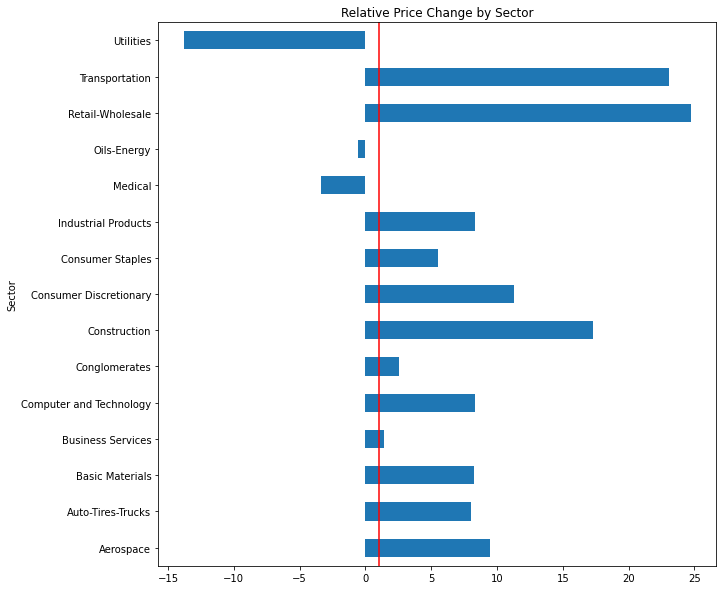

In [136]:
df2.groupby('Sector')['Relative Price Change'].median().plot.barh(figsize=(10,10),)
plt.axvline(x=1, color='r', linestyle='-')
plt.title('Relative Price Change by Sector')
plt.show()


As there are no missing values, we will separate out the numeric variables for now into a separate data frame to search for any outliers.

In [137]:
df2_numeric = df2.select_dtypes(include='float64')

In [138]:
df2_numeric.head()

,5 Yr. Hist. EPS Growth,5 Yr Historical Sales Growth,ROA (5 Yr Avg),ROI (5 Yr Avg),Relative Price Change
0,24.02,6.58,6.06650,9.36760,0.93
1,10.55,3.34,3.92079,5.63920,6.78
2,45.56,22.88,14.39900,16.32299,-8.66
3,68.85,56.53,9.88389,16.90999,1.61
4,8.89,18.57,11.49100,14.08300,7.01


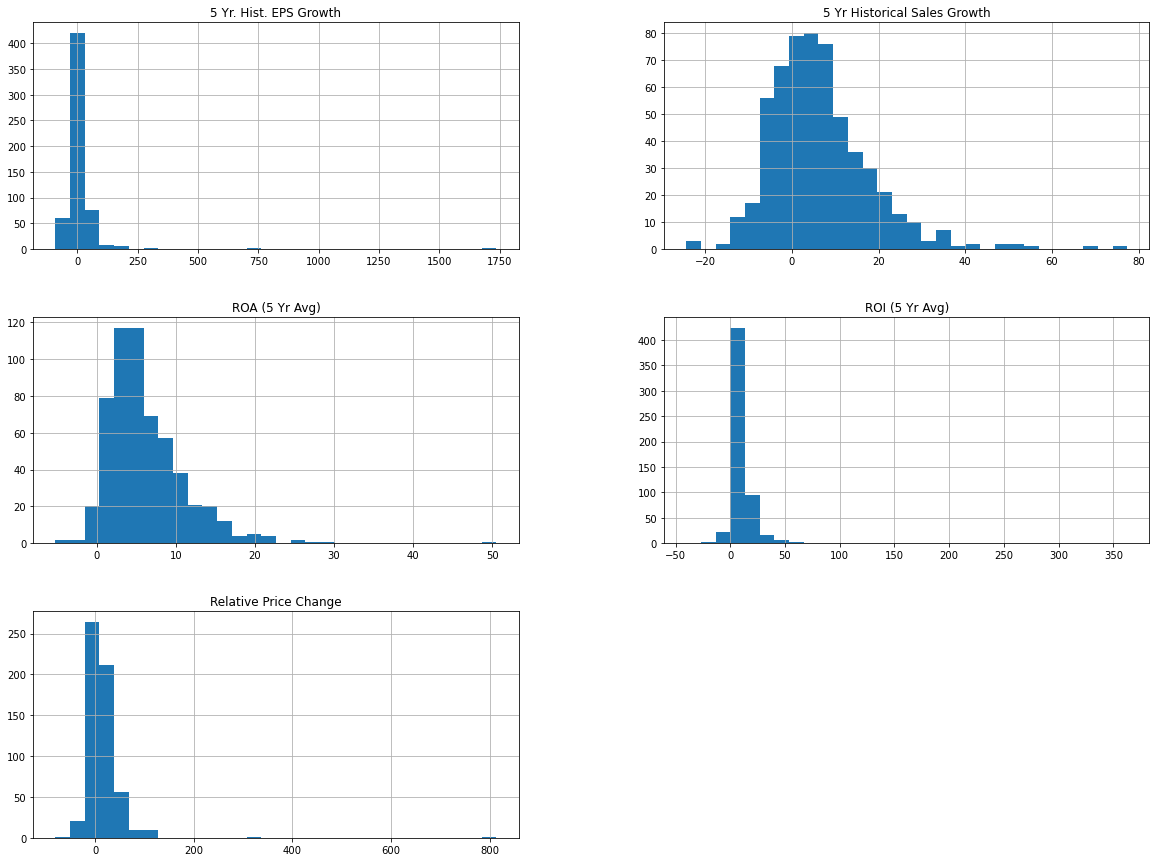

In [139]:
df2_numeric.hist(bins=30, figsize=(20, 15))
plt.show()

We will now employ an Isolation forest to remove any potential outliers from the data. An isolation forest recursively generates trees by selecting a feature and split value. Outliers will have shorter paths to reaching a leaf.

In [140]:
iso_for = IsolationForest(contamination=0.05,random_state=42,n_estimators=200)
out = iso_for.fit_predict(df2_numeric)

In [141]:
df2.loc[:,'iso'] = out

/opt/anaconda3/envs/personal_projects/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/envs/personal_projects/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [142]:
df2.head()

,Ticker,Sector,5 Yr. Hist. EPS Growth,5 Yr Historical Sales Growth,ROA (5 Yr Avg),ROI (5 Yr Avg),Relative Price Change,iso
0,FLWS,Retail-Wholesale,24.02,6.58,6.06650,9.36760,0.93,1
1,AIR,Aerospace,10.55,3.34,3.92079,5.63920,6.78,1
2,ABMD,Medical,45.56,22.88,14.39900,16.32299,-8.66,1
3,ACMR,Industrial Products,68.85,56.53,9.88389,16.90999,1.61,-1
4,ANIP,Medical,8.89,18.57,11.49100,14.08300,7.01,1


We remove companies with iso value of -1 indicating an outlier.

In [143]:
outliers = df2.loc[df2['iso']==-1]
df2_noOutliers = df2.loc[df2.index.difference(outliers.index), ]

In [144]:
outliers

,Ticker,Sector,5 Yr. Hist. EPS Growth,5 Yr Historical Sales Growth,ROA (5 Yr Avg),ROI (5 Yr Avg),Relative Price Change,iso
3,ACMR,Industrial Products,68.85,56.53,9.88389,16.90999,1.61,-1
18,ALGN,Medical,63.92,25.56,25.03899,38.16299,-5.56,-1
19,ATI,Basic Materials,758.28,3.79,1.11800,1.69700,23.41,-1
57,BNED,Consumer Discretionary,10.63,-2.29,-3.80030,-8.25431,63.42,-1
138,CORT,Medical,112.71,50.75,25.73399,32.15599,-15.01,-1
142,CROX,Consumer Discretionary,333.50,4.62,7.15990,13.46399,17.77,-1
184,EXEL,Medical,46.26,77.38,15.93000,24.40699,7.76,-1
185,EXPR,Retail-Wholesale,-55.29,-9.00,0.29025,-7.22320,322.08,-1
198,FORM,Computer and Technology,297.71,17.22,8.20300,9.94069,9.45,-1
207,GME,Retail-Wholesale,-33.31,-11.15,4.25939,5.07469,813.99,-1


In [145]:
df2_noOutliers['Relative Price Change'].describe()

count    543.000000
mean      12.966777
std       24.576435
min      -37.060000
25%       -3.865000
50%        8.480000
75%       24.610000
max      126.470000
Name: Relative Price Change, dtype: float64

Not surprisingly, GameStop (GME) appears as an outlier above. 

To build our response variable, we create two bins for relative price change: everything above 1 and everything below 1 indicating performing better or worse than the S&P YTD.

In [146]:
bins = [-100,1,200]
df2_noOutliers['binned'] = pd.cut(df2_noOutliers['Relative Price Change'], bins)

In [147]:
df2_noOutliers['binned'].value_counts()

(1, 200]     358
(-100, 1]    185
Name: binned, dtype: int64

Factorize the binned variable to 1 or 0 corresponding to invest or not invest respectively. Then we remove unnecessary columns.

In [148]:
invest = pd.factorize(df2_noOutliers['binned'])

In [149]:
df2_noOutliers['invest'] = invest[0].tolist()

In [150]:
df3 = df2_noOutliers.drop(['Ticker','iso','binned','Relative Price Change'],axis=1)

Shuffle rows.

In [151]:
df3 = df3.sample(frac=1)

In [152]:
def onehot_combine(data,column):
    
    """Function to one hot encode categorical feature
       and put back in place in the data frame."""
    
    one_hot = pd.get_dummies(data[[column]])
    data = data.drop([column],axis=1)
    res = pd.concat([data,one_hot],axis=1)
    return(res)  

Will use one hot encoder from sklearn later.

In [153]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(df3[['Sector']])

OneHotEncoder()

In [154]:
df3_final = onehot_combine(df3,column='Sector')

In [155]:
X = df3_final.loc[:, df3_final.columns != 'invest']
y = df3_final.loc[:, 'invest']

In [156]:
X.dtypes

5 Yr. Hist. EPS Growth            float64
5 Yr Historical Sales Growth      float64
ROA (5 Yr Avg)                    float64
ROI (5 Yr Avg)                    float64
Sector_Aerospace                    uint8
Sector_Auto-Tires-Trucks            uint8
Sector_Basic Materials              uint8
Sector_Business Services            uint8
Sector_Computer and Technology      uint8
Sector_Conglomerates                uint8
Sector_Construction                 uint8
Sector_Consumer Discretionary       uint8
Sector_Consumer Staples             uint8
Sector_Industrial Products          uint8
Sector_Medical                      uint8
Sector_Oils-Energy                  uint8
Sector_Retail-Wholesale             uint8
Sector_Transportation               uint8
Sector_Utilities                    uint8
dtype: object

Separate train and test. Then extract numerical and categorical columns to perform standardization on numerical columns only.

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

In [158]:
num_cols = df3_final.columns[df3_final.dtypes.apply(lambda f: np.issubdtype(f, np.float64))]

In [159]:
cat_cols = df3_final.columns[df3_final.dtypes.apply(lambda f: np.issubdtype(f, np.uint8))]

In [160]:
sc = StandardScaler()
X_train_num = sc.fit_transform(X_train[num_cols])
X_test_num = sc.transform(X_test[num_cols])
X_train_cat = X_train[cat_cols].values
X_test_cat = X_test[cat_cols].values

Merge transformed numerical variables to categorical.

In [161]:
X_train = np.hstack((X_train_num, X_train_cat))
X_test = np.hstack((X_test_num,X_test_cat))

Build model and train using cross val score. We focus on precision as false positives can lead to investments that lose money.

In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

rf = RandomForestClassifier(n_estimators=200,max_depth=3,min_samples_leaf = 20,random_state=42,class_weight = 'balanced_subsample')

clf = rf

In [182]:
cross_val_score(clf,X_train,y_train,cv=3,scoring='precision')

array([0.71428571, 0.69879518, 0.671875  ])

In [183]:
clf.fit(X_train, y_train)
preds = np.where(clf.predict_proba(X_test)[:,1]>.5,1,0)

In [184]:
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.616667
recall,0.689076
precision,0.719298
roc_auc_score,0.582243


In [185]:
from sklearn.metrics import confusion_matrix

In [186]:
cf = confusion_matrix(np.array(y_test), preds)

In [187]:
cf

array([[29, 32],
       [37, 82]])

We now train on the full data.

In [188]:
num_cols = df3_final.columns[df3_final.dtypes.apply(lambda f: np.issubdtype(f, np.float64))]

cat_cols = df3_final.columns[df3_final.dtypes.apply(lambda f: np.issubdtype(f, np.uint8))]

sc = StandardScaler()
X_num = sc.fit_transform(X[num_cols])
X_cat = X[cat_cols].values


In [189]:
X = np.hstack((X_num, X_cat))

In [190]:
clf.fit(X,y)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       min_samples_leaf=20, n_estimators=200, random_state=42)

In [191]:
# import pickle

In [192]:
# data = {'model':clf,'num_scale':sc,'cat_enc':enc}

In [193]:
# with open('saved_steps.pkl','wb') as file:
#     pickle.dump(data,file)

In [194]:
# with open('saved_steps.pkl','rb') as file:
#     data = pickle.load(file)

In [195]:
# rf = data['model']
# sc = data['num_scale']
# enc = data['cat_enc']